# GGA 的 Kohn-Sham 交换相关势函数导出

This document will take PBE as an example to obtain (pure, excluding the exact exchange part) the exchange-related potential function $v_\mathrm{xc} (\boldsymbol{r})$ of the closed shell (Restricted) GGA (Generalized Gradient Approximation). Some notation in this document will tend to [pyxdh document](https://py-xdh.readthedocs.io/zh_CN/latest/qcbasic/basic_gga.html), but all are related to functional The quantity related to the kernel or its derivative is not multiplied by the grid point weight.

In [1]:
%matplotlib notebook
from pyscf import gto, dft
import numpy as np
from functools import partial
from matplotlib import pyplot as plt

np.einsum = partial(np.einsum, optimize=["greedy", 1024 ** 3 * 4 / 8])
np.set_printoptions(5, linewidth=150, suppress=True)

/home/alexander/.conda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Slater 交换势函数导出

Before discussing the exchange-related momentum of GGA, let's discuss a relatively simple situation, that is, the Slater functional of LDA (Local Density Approximation).

We know that for the simplest exchange-related functional, the Slater functional (although it does not contain relevant parts, but is similar from an implementation perspective), its functional form is (refer to [Wikipedia page](https:/ /en.wikipedia.org/wiki/Local-density_approximation#Exchange_functional))

$$
E_\mathrm{x}^{\mathsf{Slater}}[\rho] = - \frac{3}{4}\left( \frac{3}{\pi} \right)^{1/3} \int\rho(\boldsymbol{r})^{4/3} \, \mathrm{d} \boldsymbol{r}
$$

Therefore, the exchange potential can be derived

$$
v_\mathrm{x}^\mathsf{Slater} (\boldsymbol{r}) = \frac{\delta \, E_\mathrm{x}^{\mathsf{Slater}}[\rho]}{\delta \, \rho(\boldsymbol{r})} = - \left( \frac{3}{\pi} \right)^{1/3} \rho(\boldsymbol{r})^{1/3}
$$

But the Slater functional is a kind of LDA (Local Density Approximation), and its exchange-related (although there is no relevant part) potential can be easily obtained directly through the variation of the functional; in terms of procedures, under the notation I am used to, It can also be easily obtained from (unweighted) $f_{\rho}$. Let us take the Ne atom and the 6-311G basis set as an example, take the self-consistent field density under the Slater functional, and draw its radial lattice points:

In [2]:
ni = dft.numint.NumInt()

In [4]:
mol = gto.Mole()
mol.atom = """Ne"""
mol.basis = "6-311G"
mol.verbose = 0
mol.build()

In [5]:
grids = dft.Grids(mol).build()

In [6]:
mf = dft.RKS(mol)
mf.xc = "Slater"
mf.grids = grids
mf.run()

-`rad_ngrid`: the number of radial grid points, used for drawing

-`rad_x`: the $x$ coordinate component of the radial grid point (the distance between the grid point and the nucleus), which is generated by a geometric sequence of length 1000 from $10^{-3}$ to $10^{1}$

-`rad_coord`: the three-dimensional coordinates of the radial grid point

In [7]:
rad_ngrid = 1000
rad_x = np.logspace(-3, 1, rad_ngrid)
rad_coord = np.array([rad_x, np.zeros(rad_ngrid), np.zeros(rad_ngrid)]).T

In [10]:
rad_coord

array([[ 0.001  ,  0.     ,  0.     ],
       [ 0.00101,  0.     ,  0.     ],
       [ 0.00102,  0.     ,  0.     ],
       ...,
       [ 9.8173 ,  0.     ,  0.     ],
       [ 9.90823,  0.     ,  0.     ],
       [10.     ,  0.     ,  0.     ]])

In [62]:
rad_coord.shape

(1000, 3)

-`rad_occ_0` $\phi_i (\boldsymbol{r}_g)$ molecular orbital $i$ function on the grid points, obtained by $\phi_i = \sum_\mu \phi_\mu C_{\mu i}$

-`rad_rho_0` $\rho (\boldsymbol{r}_g)$, but the density only represents the grid points on the radial $\boldsymbol{r}_g = (x_g, 0, 0)$. Although the physical meaning is the same as that of `rho_0`, the latter’s grid points are full-space and can be Grid point

In [11]:
rad_ao_0 = ni.eval_ao(mol, rad_coord, deriv=0)
rad_rho_0 = ni.eval_rho(mol, rad_ao_0, mf.make_rdm1())

In [13]:
rad_ao_0.shape

(1000, 13)

In [14]:
rad_rho_0.shape

(1000,)

`rad_xc` represents $f_\mathrm{\rho}$ obtained from the PySCF program, which is defined as

$$
f_{\rho} = \frac{\partial (f[\rho] \rho)}{\partial \rho}
$$

The $f[\rho]$ in the above formula represents the functional kernel, and its definition can be seen from the following formula

$$
E_\mathrm{xc} [\rho] = \int f[\rho] \rho(\boldsymbol{r}) \, \mathrm{d} \boldsymbol{r}
$$

Therefore, for LDA,

$$
f_{\rho} (\boldsymbol{r}) = \frac{\delta \, E_\mathrm{xc} [\rho]}{\delta \, \rho (\boldsymbol{r})} = v_\mathrm{xc} (\boldsymbol{r})
$$

The above notation can sometimes cause confusion. For example, $f_{\rho}$ can be used as a function of $\boldsymbol{r}$, and its meaning is consistent with the exchange correlation potential function $v_\mathrm{xc} (\boldsymbol{r})$; it can also be used as a functional about $\rho$, because for different densities, $f_{\rho}$ is not Same; and in the program, $f_{\rho}$ is a kind of lattice point, so it may also be used to obtain lattice point integrals. Sometimes, we abbreviate the functional kernel $f[\rho]$ as $f$. These different symbols will play different roles in different contexts; readers may need to keep an eye on these issues. Of course, the results of the program are certain and can be used for verification.

We then use `rad_xc_anal_expression`, take the exact expression of Slater exchange correlation potential, to verify that the exchange correlation potential given by the PySCF program is indeed correct:

In [15]:
rad_xc = ni.eval_xc("Slater", rad_rho_0, deriv=1)[1][0]
rad_xc_anal_expression = - (3 / np.pi)**(1 / 3) * rad_rho_0**(1 / 3) 

Below we can plot the Slater exchange correlation potential. The recurring picture mentioned in the figure refers to the article of [JCTC, 2013, 9, 3959-3964](https://dx.doi.org/10.1021/ct4004146).

<IPython.core.display.Javascript object>


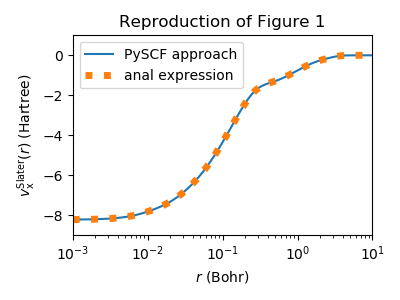

In [16]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(rad_x, rad_xc, label="PySCF approach")
ax.plot(rad_x, rad_xc_anal_expression, linestyle=":", linewidth=5, label="anal expression")
ax.set_xscale("log"), ax.legend(loc="upper left")
ax.set_xlim(1e-3, 1e1), ax.set_ylim(-9, 1)
ax.set_xlabel(r"$r$ (Bohr)")
ax.set_ylabel(r"$v_\mathrm{x}^\mathsf{Slater} (r)$ (Hartree)")
ax.set_title("Reproduction of Figure 1")
fig.tight_layout()

## PBE exchange related potential derivation

### Verification of exchange correlation potential matrix

But the same approach cannot be used in PBE functionals (or in general, pure GGA functionals). For the $v_{\mu \nu}^\mathrm{xc} [\rho] = \langle \mu | \hat v_\mathrm{xc} | \nu \rangle$ exchange correlation potential matrix used in quantification, we used to read the [pyxdh document](https://py-xdh.readthedocs.io/zh_CN/latest/qcbasic/basic_gga. html#%E4%BB%BB%E5%8A%A1-(3.3)-%E5%8F%AF%E9%80%89) has made a more detailed derivation in the task (3.3), here is the expression formula:

$$
\begin{align}
v_{\mu \nu}^\mathrm{xc} [\rho] &= \sum_r \int \big[ f_\rho \phi_\mu \phi_\nu + 2 f_\gamma \rho_r (\phi_{r \mu} \phi_{\nu} + \phi_{\mu} \phi_{r \nu}) \big] \, \mathrm{d} \boldsymbol{r} \\
&= \langle \mu | f_\rho | \nu \rangle + 2 \sum_r \langle \mu_r | f_\gamma \rho_r | \nu \rangle + 2 \sum_r \langle \mu | f_\gamma \rho_r | \nu_r \rangle
\end{align}
$$

Among them, the above formula

$$
\begin{align}
f_\gamma = \frac{\partial (f \rho)}{\partial \gamma}, \quad \rho_r = \frac{\partial \rho}{\partial r}, \quad \mu_r = \frac{\partial \mu}{\partial r}
\end{align}
$$

In the above formula, italics (not bold italics) $r$ or $w$ that will appear after represent a coordinate component of the three-dimensional electronic coordinate $\boldsymbol{r}$. If you use a more common way of writing, there are

$$
v_{\mu \nu}^\mathrm{xc} [\rho] = \langle \mu | f_\rho | \nu \rangle + 2 \langle \nabla \mu | f_\gamma \nabla \rho | \nu \rangle + 2 \langle \mu | f_\gamma \nabla \rho | \nabla \nu \rangle
$$

The two $\nabla$ gradient symbols in the above formula are calculated using the dot product inner product. We might as well use the program to verify the correctness of the above formula. We first use the PBE functional to calculate the self-consistent field process again:

In [17]:
mf = dft.RKS(mol)
mf.xc = "PBE"
mf.grids = grids
mf.run()

-`C` $C_{\mu p}$ molecular orbital coefficient matrix

-`D` $D_{\mu \nu}$ electron density matrix

In [18]:
C = mf.mo_coeff
D = mf.make_rdm1()

In [19]:
C.shape

(13, 13)

In [20]:
D.shape

(13, 13)

-ʻAo_0` $\phi_\mu$, ʻao_1` $\phi_{r \mu} = \partial_r \phi_\mu$, ʻao_2` $\phi_{rw \mu} = \partial_r \partial_w \phi_\mu$ are the atomic orbital function lattice points and their derivatives

In [21]:
ao = ni.eval_ao(mol, grids.coords, deriv=2)
ao_0, ao_1 = ao[0], ao[1:4]
ao_2 = np.array([
    [ao[4], ao[5], ao[6]],
    [ao[5], ao[7], ao[8]],
    [ao[6], ao[8], ao[9]],
])

In [22]:
ao.shape

(10, 12066, 13)

In [23]:
ao_0.shape

(12066, 13)

In [24]:
ao_1.shape

(3, 12066, 13)

In [36]:
ao_2.shape

(3, 3, 12066, 13)

-`rho_0` $\rho$, `rho_1` $\rho_r = \partial_r \rho$, `rho_2` $\rho_{rw} = \partial_r \partial_w \rho$ are the electronic density of states grid points

In [25]:
rho_0 = np.einsum("gu, gv, uv -> g", ao_0, ao_0, D)
rho_1 = 2 * np.einsum("rgu, gv, uv -> rg", ao_1, ao_0, D)
rho_2 = (
    + 2 * np.einsum("rwgu, gv, uv -> rwg", ao_2, ao_0, D)
    + 2 * np.einsum("rgu, wgv, uv -> rwg", ao_1, ao_1, D)
)

In [26]:
rho_0.shape

(12066,)

In [35]:
rho_1.shape

(3, 12066)

In [34]:
rho_2.shape

(3, 3, 12066)

- `gamma_0` $\gamma = \nabla \rho \cdot \nabla \rho$, `gamma_1` $\gamma_r = \partial_r \gamma$

In [37]:
gamma_0 = np.einsum("rg, rg -> g", rho_1, rho_1)
gamma_1 =  2 * np.einsum("rwg, wg -> rg", rho_2, rho_1)

In [38]:
gamma_0.shape

(12066,)

In [39]:
gamma_1.shape

(3, 12066)

-`fr` $f_\rho$, `fg` $f_\gamma$, `frr` $f_{\rho \rho}$, `frg` $f_{\rho \gamma}$, `fgg` $f_{\gamma \gamma}$ represent the derivation of the functional kernel and density product $f \rho$, the subscript represents the derivation object

In [40]:
_, vxc, fxc, _ = ni.eval_xc("PBE, PBE", np.concatenate([rho_0[None, :], rho_1]), deriv=2)
fr, fg = vxc[:2]
frr, frg, fgg = fxc[:3]

Then, the exchange correlation matrix $v_{\mu \nu}^\mathrm{xc}$ can be expressed by `Vxc`:

In [41]:
Vxc = (
    + np.einsum("g, g, gu, gv -> uv", grids.weights, fr, ao_0, ao_0)
    + 2 * np.einsum("g, g, rg, rgu, gv -> uv", grids.weights, fg, rho_1, ao_1, ao_0)
    + 2 * np.einsum("g, g, rg, gu, rgv -> uv", grids.weights, fg, rho_1, ao_0, ao_1)
)

In [42]:
Vxc.shape

(13, 13)

The method of verifying `Vxc` $v_{\mu \nu}^\mathrm{xc}$ can be to generate the Fock matrix under the molecular orbital. We know that the Fock matrix of Canonical RKS is diagonal. We use this property to verify:

In [17]:
F = (
    + np.einsum("uv, up, vq -> pq", mol.intor("int1e_kin"), C, C)
    + np.einsum("uv, up, vq -> pq", mol.intor("int1e_nuc"), C, C)
    + np.einsum("uvkl, kl, up, vq -> pq", mol.intor("int2e"), D, C, C)
    + np.einsum("uv, up, vq -> pq", Vxc, C, C)
)

For the aesthetics of the document, we only show the Fock matrix that occupies the track part; if the reader executes the code by himself, it is not difficult to verify that the other parts also follow the diagonal matrix.

In [18]:
F[:5, :5]

array([[-30.44674,  -0.     ,   0.     ,   0.     ,   0.     ],
       [ -0.     ,  -1.30498,  -0.     ,  -0.     ,  -0.     ],
       [  0.     ,  -0.     ,  -0.46122,  -0.     ,   0.     ],
       [  0.     ,  -0.     ,  -0.     ,  -0.46122,   0.     ],
       [ -0.     ,  -0.     ,  -0.     ,   0.     ,  -0.46122]])

### Exchange correlation potential as the derivation of the radial function

Let us review the calculation of the exchange correlation potential:

$$
v_{\mu \nu}^\mathrm{xc} [\rho] = \langle \mu | f_\rho | \nu \rangle + 2 \langle \nabla \mu | f_\gamma \nabla \rho | \nu \rangle + 2 \langle \mu | f_\gamma \nabla \rho | \nabla \nu \rangle
$$

But from the above style, from the above style we may be able to write less rigorously

$$
\hat v_\mathrm{xc} = f_\rho + 2 f_\gamma \nabla \rho \cdot \nabla + 2 \nabla {\square} \cdot f_\gamma \nabla \rho
$$

But we can't get the information of $v_\mathrm{xc} (\boldsymbol{r})$ directly from the above expression. For this, we need to rearrange the above formula as

$$
v_{\mu \nu}^\mathrm{xc} [\rho] = \langle \mu | f_\rho | \nu \rangle + 2 \langle f_\gamma \nabla \rho | \nabla (\mu \nu) \rangle
$$

For the second term on the right side of the above equation, we can use Gauss theorem (similar to partial integration) and the nature of the wave function itself at infinity to transform it

$$
\begin{align}
2 \langle f_\gamma \nabla \rho | \nabla (\mu \nu) \rangle &= 2 \int f_\gamma \nabla \rho \cdot \nabla (\phi_\mu \phi_\nu) \, \mathrm{d} \boldsymbol{r} \\
&= 2 \int_{\Sigma} \nabla \cdot (\phi_\mu \phi_\nu f_\gamma \nabla \rho) \, \mathrm{d} \boldsymbol{\Sigma} - 2 \int \phi_\mu \phi_\nu \nabla \cdot (f_\gamma \nabla \rho) \, \mathrm{d} \boldsymbol{r} \\
&= 0 - 2 \int \phi_\mu \phi_\nu \big[ f_{\rho \gamma} \nabla \rho \cdot \nabla \rho + f_{\gamma \gamma} \nabla \gamma \cdot \nabla \rho + f_\gamma \nabla^2 \rho \big] \, \mathrm{d} \boldsymbol{r}
\end{align}
$$

In the above formula, the surface referred to by $\Sigma$ is a simply connected surface extending to infinity. According to the characteristics of the wave function, the value of one term of the second type surface integral containing $\mathrm{d} \boldsymbol{\Sigma}$ in the above formula is zero.

We can use the conclusion of the above formula to generate `Vxc_`, and verify with `Vxc` to check whether it is correct:

In [43]:
Vxc_ = (
    + np.einsum("g, gu, gv, g -> uv", grids.weights, ao_0, ao_0, fr)
    - 2 * np.einsum("g, gu, gv, g, rg, rg -> uv", grids.weights, ao_0, ao_0, frg, rho_1, rho_1)
    - 2 * np.einsum("g, gu, gv, g, rg, rg -> uv", grids.weights, ao_0, ao_0, fgg, gamma_1, rho_1)
    - 2 * np.einsum("g, gu, gv, g, gr -> uv", grids.weights, ao_0, ao_0, fg, rho_2.diagonal())
)

In [45]:
Vxc_.shape

(13, 13)

In [44]:
np.allclose(Vxc, Vxc_)

True

Therefore, the above-mentioned derivation and procedures are confirmed. We can write

$$
\begin{align}
v_{\mu \nu}^\mathrm{xc} [\rho] &= \langle \mu | f_\rho | \nu \rangle + 2 \langle \nabla \mu | f_\gamma \nabla \rho | \nu \rangle + 2 \langle \mu | f_\gamma \nabla \rho | \nabla \nu \rangle \\
&= \langle \mu | f_\rho - 2 f_{\rho \gamma} \nabla \rho \cdot \nabla \rho - 2 f_{\gamma \gamma} \nabla \gamma \cdot \nabla \rho - 2 f_\gamma \nabla^2 \rho | \nu \rangle
\end{align}
$$

Therefore, it can be written naturally now that the exchange correlation potential as a function of electronic coordinates can be written as

$$
\hat v_\mathrm{xc} = v_\mathrm{xc} (\boldsymbol{r}) = f_\rho - 2 f_{\rho \gamma} \nabla \rho \cdot \nabla \rho - 2 f_{\gamma \gamma} \nabla \gamma \cdot \nabla \rho - 2 f_\gamma \nabla^2 \rho
$$

It should be noted that this is the case for GGA. For LDA (like the Slater functional discussed at the beginning), since $f \rho$ is not a functional of $\gamma = \nabla \rho \cdot \nabla \rho$, it will naturally degenerate into $v_\mathrm{xc}^\mathsf{GGA} (\boldsymbol{r}) = f_\rho$.

### Ne atom 6-311G PBE exchange correlation potential under basis set: image rendering

Now that we have verified the correctness and feasibility of obtaining the exchange correlation potential above, we may as well plot the exchange correlation potential at the distance from Ne atom $10^{-2}$ to $10^{1}$ Bohr. The following code is no longer explained, and its meaning is believed to have been described above enough.

In [46]:
rad_ao = ni.eval_ao(mol, rad_coord, deriv=2)
rad_ao_0, rad_ao_1 = rad_ao[0], rad_ao[1:4]
rad_ao_2 = np.array([
    [rad_ao[4], rad_ao[5], rad_ao[6]],
    [rad_ao[5], rad_ao[7], rad_ao[8]],
    [rad_ao[6], rad_ao[8], rad_ao[9]],
])

In [48]:
rad_ao.shape

(10, 1000, 13)

In [49]:
rad_ao_0.shape

(1000, 13)

In [50]:
rad_ao_1.shape

(3, 1000, 13)

In [51]:
rad_ao_2.shape

(3, 3, 1000, 13)

In [52]:
rad_rho_0 = np.einsum("gu, gv, uv -> g", rad_ao_0, rad_ao_0, D)
rad_rho_1 = 2 * np.einsum("rgu, gv, uv -> rg", rad_ao_1, rad_ao_0, D)
rad_rho_2 = (
    + 2 * np.einsum("rwgu, gv, uv -> rwg", rad_ao_2, rad_ao_0, D)
    + 2 * np.einsum("rgu, wgv, uv -> rwg", rad_ao_1, rad_ao_1, D)
)

In [53]:
rad_rho_0.shape

(1000,)

In [54]:
rad_rho_1.shape

(3, 1000)

In [55]:
rad_rho_2.shape

(3, 3, 1000)

In [56]:
rad_gamma_0 = np.einsum("rg, rg -> g", rad_rho_1, rad_rho_1)
rad_gamma_1 =  2 * np.einsum("rwg, wg -> rg", rad_rho_2, rad_rho_1)

In [57]:
rad_gamma_0.shape

(1000,)

In [58]:
rad_gamma_1.shape

(3, 1000)

In [59]:
_, rad_vxc, rad_fxc, _ = ni.eval_xc("PBE, PBE", np.concatenate([rad_rho_0[None, :], rad_rho_1]), deriv=2)
rad_fr, rad_fg = rad_vxc[:2]
rad_frr, rad_frg, rad_fgg = rad_fxc[:3]

In [60]:
rad_xc = (
    + rad_fr
    - 2 * np.einsum("g, rg, rg -> g", rad_frg, rad_rho_1, rad_rho_1)
    - 2 * np.einsum("g, rg, rg -> g", rad_fgg, rad_gamma_1, rad_rho_1)
    - 2 * np.einsum("g, gr -> g", rad_fg, rad_rho_2.diagonal())
)

In [61]:
rad_xc.shape

(1000,)

Finally, we can draw it. The recurring picture mentioned in the figure refers to the article of [JCTC, 2013, 9, 3959-3964](https://dx.doi.org/10.1021/ct4004146).

<IPython.core.display.Javascript object>


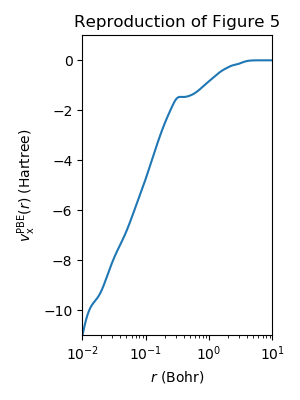

In [63]:
fig, ax = plt.subplots(figsize=(3, 4))
ax.plot(rad_x, rad_xc)
ax.set_xscale("log")
ax.set_xlim(1e-2, 1e1), ax.set_ylim(-11, 1)
ax.set_xlabel(r"$r$ (Bohr)")
ax.set_ylabel(r"$v_\mathrm{x}^\mathsf{PBE} (r)$ (Hartree)")
ax.set_title("Reproduction of Figure 5")
fig.tight_layout()